# Diagnosing relationship of breaths to ventilator using edit distances

Import libraries

In [1]:
#%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
from numpy import diff
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as interp
import textdistance
import collections
import math



In [2]:
# get new changes in our library i.e. the tmsisdk

sys.path.insert(0, '../resurfemg')
import helper_functions as hf

from tmsisdk_lite import Poly5Reader

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


Here we will load signals processed to have an emg and ventilator signal time matched. Right now we have a very small group of two that are downsampled, and one upsampled.

In [3]:
# do not rerun this cell
big_data_list= []

In [4]:
stacked_emg_directory = '../researcher_interface/output_emg_processed'
os.listdir(stacked_emg_directory )

['not_pushedtopspin_data_anonymizedM001001EMG_recording',
 'not_pushedtopspin_data_anonymizedM001002EMG_recording',
 'not_pushedtopspin_data_anonymizedM002005EMG_recording']

The 001001 is upsampled, the others are downsampled.

In [5]:
#os.listdir()
# put in a chooser widget here

In [6]:
file_name = os.path.join(stacked_emg_directory,'not_pushedtopspin_data_anonymizedM002005EMG_recording')
file_name2 = os.path.join(stacked_emg_directory,'not_pushedtopspin_data_anonymizedM001002EMG_recording')
file_name3 = os.path.join(stacked_emg_directory,'not_pushedtopspin_data_anonymizedM001001EMG_recording')

In [7]:
file = np.load(file_name)

In [8]:
file

array([[ 7.03945975e-05, -4.59417200e-03, -5.48236952e-03, ...,
        -1.03932648e-03, -9.48208055e-04, -1.08099285e-05],
       [ 5.02129984e+00,  5.02129984e+00,  5.07130003e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.97669983e+00, -6.61670017e+00, -6.34660006e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.86008987e+01,  4.72509003e+01,  4.59007988e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e-02,  2.00000000e-02, ...,
         4.64070000e+02,  4.64080000e+02,  4.64090000e+02]])

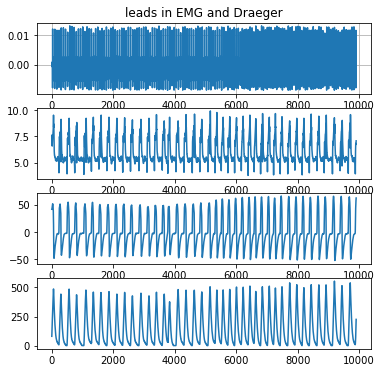

In [9]:
%matplotlib inline
# set up plot, show
x_emg = file
#x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(6, 6))
axis[0,].grid(True)
axis[0,].plot(x_emg[0][100:10000])
axis[0,].set(title='leads in EMG and Draeger')
axis[1,].plot(x_emg[1][100:10000])
axis[2,].plot(x_emg[2][100:10000])
axis[3,].plot(x_emg[3][100:10000])


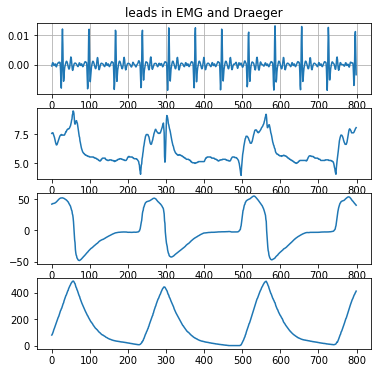

In [10]:
%matplotlib inline
# set up plot, show
x_emg = file
#x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(6, 6))
axis[0,].grid(True)
axis[0,].plot(x_emg[0][100:900])
axis[0,].set(title='leads in EMG and Draeger')
axis[1,].plot(x_emg[1][100:900])
axis[2,].plot(x_emg[2][100:900])
axis[3,].plot(x_emg[3][100:900])

# OK downsampling has made this a nightmare...but let's continue for the sake of algorithm development.

Let's examing how well the ventilator signals line up.

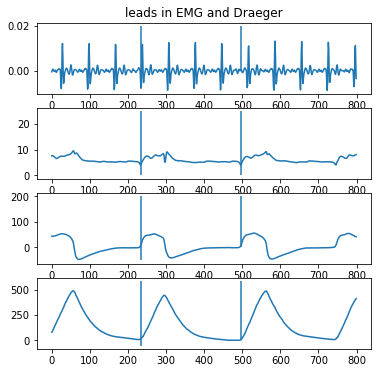

In [11]:
%matplotlib inline
# set up plot, show
x_emg = file
#x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(6, 6),)
min = x_emg.min()
max = x_emg.max()

axis[0,].set(title='leads in EMG and Draeger')
axis[0,].plot(x_emg[0][100:900])
axis[0,].vlines(235, 0, 0.02)
axis[0,].vlines(497, 0, 0.02)
axis[1,].plot(x_emg[1][100:900])
axis[1,].vlines(235, 0, 25)
axis[1,].vlines(497, 0, 25)
axis[2,].plot(x_emg[2][100:900])
axis[2,].vlines(235, min, 200)
axis[2,].vlines(497, 0, 200)
axis[3,].plot(x_emg[3][100:900])
axis[3,].vlines(235, min, max)
axis[3,].vlines(497, 0, max)

# OK, b ecause of the way our signal was processed, we will imagine we want to match ECG peaks to the vent signal...this is all to build an algorithm

We first need to break down the ventilator signal

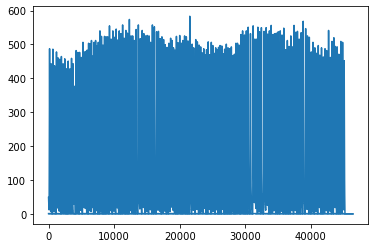

In [12]:
low_per = 0.05
plt.plot(hf.zero_one_for_jumps_base(
            x_emg[3], x_emg[3].max()*low_per), color='C0')
plt.plot(x_emg[3])

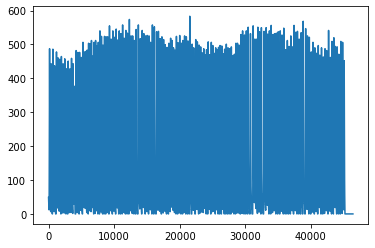

In [13]:
plt.plot(x_emg[3])

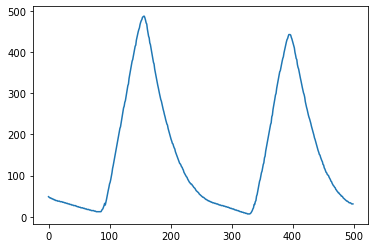

In [14]:
plt.plot(x_emg[3][0:500])

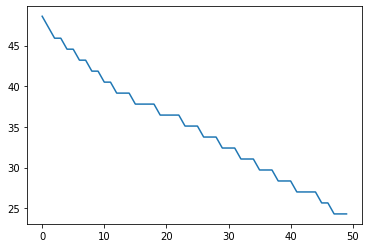

In [15]:
plt.plot(x_emg[3][0:50])

On the third lead we can tag the turns to give us insight into the ventilator activity. We can use the derivate. But we must first smooth the curve

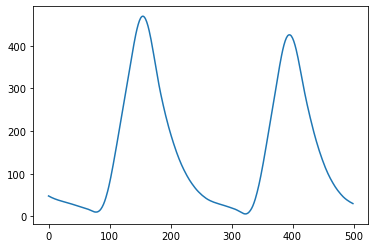

In [16]:
yhat = scipy.signal.savgol_filter(x_emg[3], 51, 3)
plt.plot(yhat[0:500])

In [17]:
from numpy import diff
dx = 1
y = yhat
dy = diff(y)/dx
print (dy)
#array([ 10.,  10.,  10.,   0.,  10.,  10.])

[-0.78605396 -0.75807204 -0.7311018  ...  0.          0.
  0.        ]


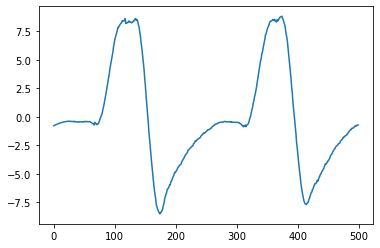

In [18]:
plt.plot(dy[0:500])

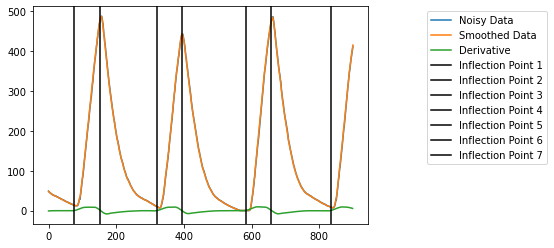

In [19]:
raw = (x_emg[3][0:900])
# smooth
smooth_data =  scipy.signal.savgol_filter(x_emg[3], 10, 3)
smooth_data = smooth_data[0:900]

# compute derivative

smooth_d2 = diff(smooth_data)/dx
smooth_d2 = scipy.signal.savgol_filter(smooth_d2, 50, 3)

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.plot(raw, label='Noisy Data')
plt.plot(smooth_data, label='Smoothed Data')
plt.plot(smooth_d2 , label='Derivative ')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

# now let's tag ventilator pushes-
we could say we have different kinds of inflections.
one headed up, and one headed down.

One approach would be to tag start and stop seperately

In [20]:
inflections_up= []
inflections_down = []
for point in infls:
    if smooth_data[(point+30)] > smooth_data[point]:
        inflections_up.append(point)
    else:
        inflections_down.append(point)
    
print("ups", inflections_up)
print("downs", inflections_down)

ups [76, 321, 582, 833]
downs [153, 393, 658]


We can also probably just use where derviate is greater than zero.

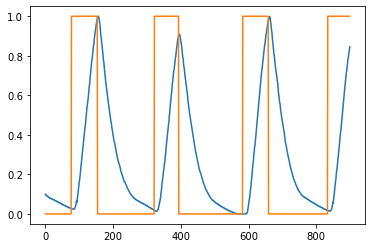

In [21]:
plt.plot(raw/raw.max())# scaled raw data in blue
#plt.plot(smooth_d2 )
cut_off = 0
zero_one_derviv = hf.zero_one_for_jumps_base(smooth_d2, cut_off)
plt.plot(zero_one_derviv)

Note that due to smoothing we pushed the start of ventilation back in time. Good enough for now. Now let's create a lagging and leading situation

# Warning: synthetic data
(we are using synthetic data here for the human)

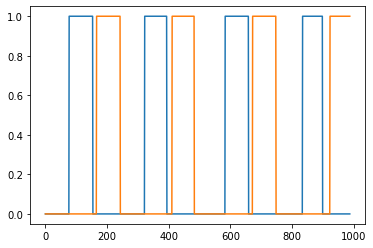

In [22]:
signal1_machine= np.append(zero_one_derviv,np.zeros(89))
signal2_psuedohuman = np.append(np.zeros(89), zero_one_derviv)
#signal2_psuedohuman = np.append(np.zeros(99), zero_one_derviv)
plt.plot(signal1_machine)
plt.plot(signal2_psuedohuman)

In [23]:
# can we diagnose the percentage overlap?
# Can we diagnose the human as before or breating after the machine?

# we assume a synchrony point on zero

In [24]:
print(type(signal2_psuedohuman))

<class 'numpy.ndarray'>


In [25]:
raw_overlap_percent = sum(signal1_machine.astype(int) & signal2_psuedohuman.astype(int))/len(signal1_machine.astype(int))
raw_overlap_percent

0.0

In [26]:
# def raw_overlap_percent(signal1, signal2):
#     if len(signal1) != len(signal2):
#         print('Warning: legnth of arrays is not matched')
#     raw_overlap_percent = sum(signal1.astype(int) & signal2.astype(int))/len(signal1.astype(int))
#     return raw_overlap_percent

In [27]:
hf.raw_overlap_percent(signal1_machine, signal2_psuedohuman)

0.0

Can we use 'edit distance' to descibe similarity?, what does edit distacnce tell us?
Let's examine an example for later discussion with scientists

In [28]:

# S1=[1,2,3,7,9,15,19,20,100,100,100]
# S2=[100,100,1,1,2,3,7,8,14,20,24]
S1 = [0,0,0,0,1,1,1,0,0,0]
S2 = [0,1,0,0,1,1,1,0,0,1]
S3 = [0,1,0,1,0,1,0,1,0,1]
S4 = [1,1,1,1,1,1,1,1,1,1]
S5 = [0,0,0,0,0,1,1,1,1,0]
S6 = [0,0,0,1,1,1,1,0,0,0]
print(textdistance.levenshtein.similarity(S1,S1))
print(textdistance.levenshtein.similarity(S1,S2))
print(textdistance.levenshtein.similarity(S1,S3))
print(textdistance.levenshtein.similarity(S1,S4))
print(textdistance.levenshtein.similarity(S1,S5))
print(textdistance.levenshtein.similarity(S1,S6))
#textdistance.levenshtein.distance(S1,S2)

10
8
5
3
7
9


So we see in theory the textdifference  levenshtein algorithm could tell us something, even if we have an  'alphabet' greaterthan zeros and ones. This gives us more information than raw overlap. 

We can also compare counts of each activity. 

In [29]:
def mismatch_breath_count(signal1_machine,signal2_human):
    machine_breaths = hf.count_decision_array(signal1_machine)
    human_breaths = hf.count_decision_array(signal2_human)
    unmatched_efforts = human_breaths - machine_breaths
    return unmatched_efforts

In [30]:
mismatch_breath_count(signal1_machine,signal2_psuedohuman)

-0.5

In [31]:
machine_breaths = hf.count_decision_array(signal1_machine)
human_breaths = hf.count_decision_array(signal2_psuedohuman)
unmatched_efforts = human_breaths - machine_breaths
unmatched_efforts

-0.5

The above could be normalized to total machine or human efforts.

In [32]:
# #machine_breaths_set = []
# human_breaths_set = []
# # for i in np.where(signal1_machine ==1):
# #     machine_breaths_set.append(i)
# where_machine=np.where(signal1_machine ==1)
# x_hashable = map(tuple, where_machine)
# machine_breaths_set= set(x_hashable) 

# human_breaths_set= set(y_hashable)
# #human_breath_set= set(np.where(signal2_psuedohuman ==1))
# machine_breaths_set

In [33]:
#len(signal2_psuedohuman)

In [34]:
# signal2_psuedohuman_list= []
# for element in signal2_psuedohuman:
#     signal2_psuedohuman_list.append(element)
# print(len(signal2_psuedohuman_list))
# signal1_machine_list= []
# for element in signal1_machine:
#     signal1_machine_list.append(element)
# print(len(signal1_machine_list))

In [35]:

# print(textdistance.levenshtein.similarity(signal1_machine_list,signal2_psuedohuman_list))
hf.relative_levenshtein(signal1_machine, signal2_psuedohuman)

0.819838056680162

# Let's try another file

In [36]:
file = np.load(file_name2)

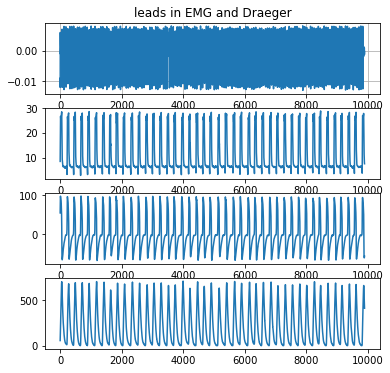

In [37]:
%matplotlib inline
# set up plot, show
x_emg = file
#x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(6, 6))
axis[0,].grid(True)
axis[0,].plot(x_emg[0][100:10000])
axis[0,].set(title='leads in EMG and Draeger')
axis[1,].plot(x_emg[1][100:10000])
axis[2,].plot(x_emg[2][100:10000])
axis[3,].plot(x_emg[3][100:10000])

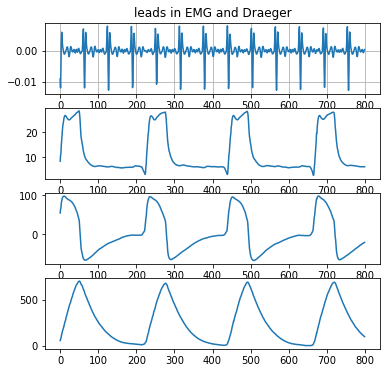

In [38]:
%matplotlib inline
# set up plot, show
x_emg = file
#x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(6, 6))
axis[0,].grid(True)
axis[0,].plot(x_emg[0][100:900])
axis[0,].set(title='leads in EMG and Draeger')
axis[1,].plot(x_emg[1][100:900])
axis[2,].plot(x_emg[2][100:900])
axis[3,].plot(x_emg[3][100:900])

Evaluating the ventilator based on derivative of smoothed(savgol filtered)

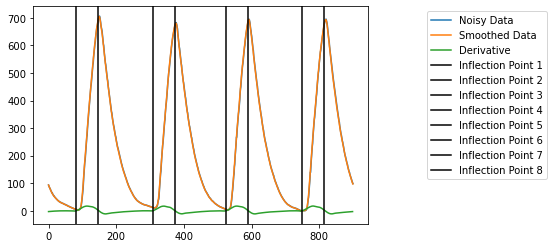

In [39]:
raw = (x_emg[3][0:900])
# smooth
smooth_data =  scipy.signal.savgol_filter(x_emg[3], 10, 3)
smooth_data = smooth_data[0:900]

# compute derivative

smooth_d2 = diff(smooth_data)/dx
smooth_d2 = scipy.signal.savgol_filter(smooth_d2, 50, 3)

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.plot(raw, label='Noisy Data')
plt.plot(smooth_data, label='Smoothed Data')
plt.plot(smooth_d2 , label='Derivative ')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

In [40]:
# tag the ventilator pushes
inflections_up= []
inflections_down = []
for point in infls:
    if smooth_data[(point+30)] > smooth_data[point]:
        inflections_up.append(point)
    else:
        inflections_down.append(point)
    
print("ups", inflections_up)
print("downs", inflections_down)

ups [82, 309, 525, 750]
downs [147, 373, 589, 815]


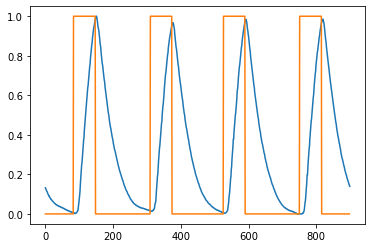

In [41]:
plt.plot(raw/raw.max())# scaled raw data in blue
#plt.plot(smooth_d2 )
cut_off = 0
zero_one_derviv = hf.zero_one_for_jumps_base(smooth_d2, cut_off)
plt.plot(zero_one_derviv)

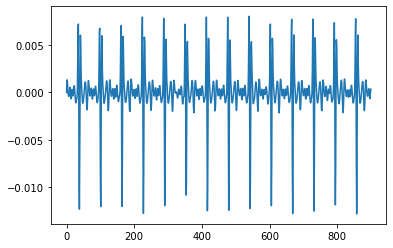

In [42]:
# Now we need to get the human breaths. We will look at our EMG and assume a simple breath counting algorithm.
raw_human = (x_emg[0][0:900])
# show
plt.plot(raw_human)

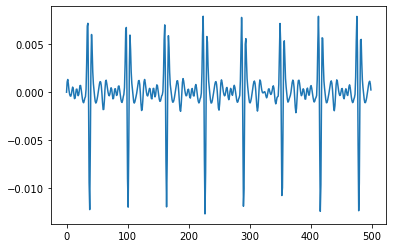

In [43]:
plt.plot(raw_human[0:500])

# Warning synthetic data ahead, again

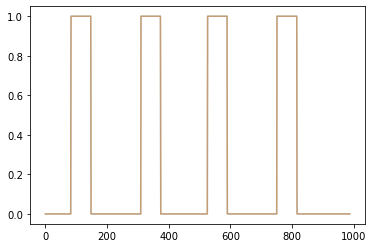

In [44]:
signal1_machine= np.append(zero_one_derviv,np.zeros(89))
signal2_psuedohuman = np.append( zero_one_derviv, np.zeros(89))
#signal2_psuedohuman = np.append(np.zeros(99), zero_one_derviv)
plt.plot(signal1_machine, alpha = 0.5)
plt.plot(signal2_psuedohuman, alpha = 0.5)

In [45]:
# signal2_psuedohuman_list= []
# for element in signal2_psuedohuman:
#     signal2_psuedohuman_list.append(element)
# print(len(signal2_psuedohuman_list))
# signal1_machine_list= []
# for element in signal1_machine:
#     signal1_machine_list.append(element)
# print(len(signal1_machine_list))

In [46]:
#print(textdistance.levenshtein.similarity(signal1_machine_list,signal2_psuedohuman_list))

In [47]:
# def relative_levenshtein(signal1, signal2):
#     """
#     Here we take two arrays, and create an edit distance based on Levelshtien edit distance
#     The distance is then normalized between 0 and one regardless of signal legnth
    
#     """
#     signal1_list= []
#     signal2_list= []
#     for element in signal1:
#         signal1_list.append(element)
#     for element in signal2:
#         signal2_list.append(element)
#     distance = textdistance.levenshtein.similarity(signal1_list,signal2_list)
#     if len(signal1) != len(signal2):
#         print('Warning: legnth of arrays is not matched')
#     longer_signal_len = np.max([len(signal1), len(signal2)])
#     normalized_distance = distance/ longer_signal_len
#     return normalized_distance

    

In [48]:
hf.relative_levenshtein(signal1_machine, signal2_psuedohuman)

1.0

# We had a problem using the real human signal because it was undersampled. let's try one less undersampled. Let's go all the way to oversampling the Drager array, and see what happens

In [49]:
file = np.load(file_name3)

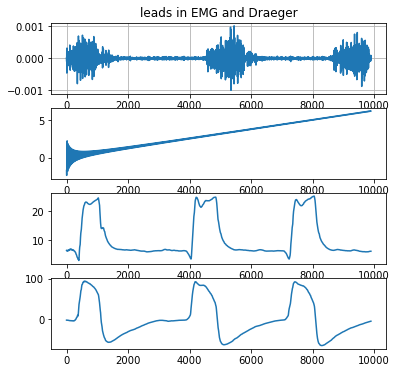

In [50]:
%matplotlib inline
# set up plot, show
x_emg = file
#x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(6, 6))
axis[0,].grid(True)
axis[0,].plot(x_emg[0][100:10000])
axis[0,].set(title='leads in EMG and Draeger')
axis[1,].plot(x_emg[1][100:10000])
axis[2,].plot(x_emg[2][100:10000])
axis[3,].plot(x_emg[3][100:10000])

Lead one must be examined, and perhaps whole sample, something strange

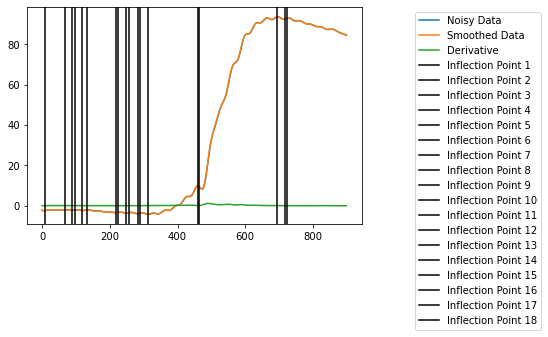

In [51]:
raw = (x_emg[3][0:900])
# smooth
smooth_data =  scipy.signal.savgol_filter(x_emg[3], 10, 3)
smooth_data = smooth_data[0:900]

# compute derivative

smooth_d2 = diff(smooth_data)/dx
smooth_d2 = scipy.signal.savgol_filter(smooth_d2, 50, 3)

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.plot(raw, label='Noisy Data')
plt.plot(smooth_data, label='Smoothed Data')
plt.plot(smooth_d2 , label='Derivative ')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

So we discovered smoothing must be adjusted in upsampled datasets...let's take more signal

In [52]:
5*10 *2400/100

1200.0

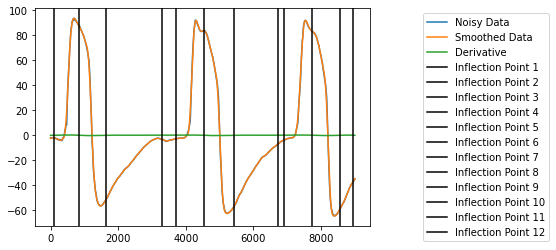

In [53]:
raw = (x_emg[3][0:9000])
# smooth
smooth_data =  scipy.signal.savgol_filter(x_emg[3], 240, 3)
smooth_data = smooth_data[0:9000]

# compute derivative

smooth_d2 = diff(smooth_data)/dx
smooth_d2 = scipy.signal.savgol_filter(smooth_d2, 1200, 3)

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.plot(raw, label='Noisy Data')
plt.plot(smooth_data, label='Smoothed Data')
plt.plot(smooth_d2 , label='Derivative ')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

Looking past this obvious mess, let's see how we do on a vent signal to breath by processing the vent signal

In [54]:
print(type(raw))

<class 'numpy.ndarray'>


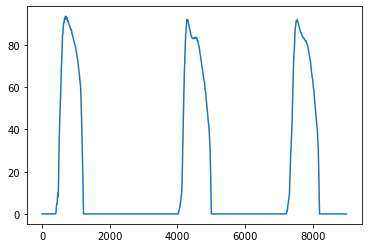

In [55]:
raw= raw.clip(min=0)
plt.plot(raw)

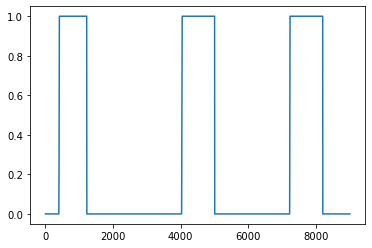

In [56]:
raw= raw.clip(max=1)
plt.plot(raw)

In [57]:
# #raw = (x_emg[3][0:9000])
# # smooth
# smooth_data =  scipy.signal.savgol_filter(raw, 240, 3)
# smooth_data = smooth_data[0:9000]

# # compute derivative

# smooth_d2 = diff(smooth_data)/dx
# smooth_d2 = scipy.signal.savgol_filter(smooth_d2, 1000, 3)

# # find switching points
# infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# # plot results
# plt.plot(raw, label='Noisy Data')
# plt.plot(smooth_data, label='Smoothed Data')
# plt.plot(smooth_d2 , label='Derivative ')
# for i, infl in enumerate(infls, 1):
#     plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
# plt.legend(bbox_to_anchor=(1.55, 1.0))

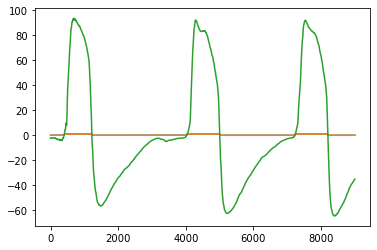

In [58]:
plt.plot(raw/raw.max())# scaled raw data in blue
#plt.plot(smooth_d2 )
cut_off = 0.5
zero_one_derviv = hf.zero_one_for_jumps_base(raw, cut_off)
plt.plot(zero_one_derviv)
plt.plot( (x_emg[3][0:9000]))

# Here not synthetic

In [59]:
human_signal = (x_emg[0][0:9000])
abs_human_signal = abs(human_signal)
smooth_human = scipy.signal.savgol_filter(abs_human_signal, 240, 3)
human_cut = hf.zero_one_for_jumps_base(smooth_human, 0.0001)

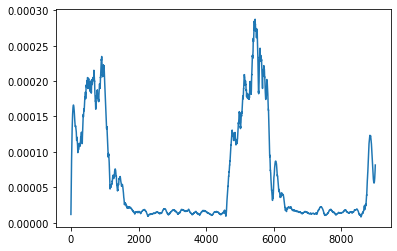

In [60]:
plt.plot(smooth_human)

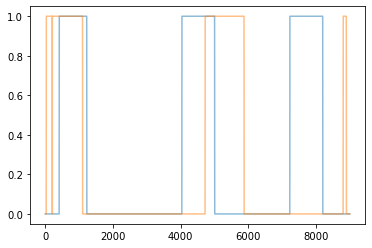

In [61]:

signal1_machine = zero_one_derviv
signal2_human = human_cut
#signal2_psuedohuman = np.append(np.zeros(99), zero_one_derviv)
plt.plot(signal1_machine, alpha = 0.5)
plt.plot(signal2_human, alpha = 0.5)

# Holding our breath about how signal processing was hard coded we now see there is a mismatch between the human and ventilaor!

Let's quantify it

In [ ]:
hf.relative_levenshtein(signal1_machine, signal2_human)

In [ ]:
mismatch_breath_count(signal1_machine,signal2_human)

In [ ]:
#hf.raw_overlap_percent(signal1_machine, signal2_human)

In [ ]:
signal1a = np.array(signal1_machine)
signal2a = np.array(signal2_human)
raw_overlap_percent = sum(
     signal1a.astype(int) & signal2a.astype(int)
 ) / len(signal1a)
raw_overlap_percent   